<a href="https://colab.research.google.com/github/Hanina-ka/crime-pattern-analysis-ml/blob/main/CrimeTypeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.inspection import permutation_importance


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

import folium
from folium.plugins import HeatMap

from tabulate import tabulate

##Reading and Exploring Data

In [ ]:
# Reading CSV data
df = pd.read_csv("/content/crime.csv")

# Making a copy of the dataframe
data = df.copy()

# Checking for null values in all columns
df.isna().sum()

# Exploring categorical variables
print(df['TYPE'].value_counts())
print(df['NEIGHBOURHOOD'].value_counts())
#dropping null values
df.dropna(inplace = True)


FileNotFoundError: [Errno 2] No such file or directory: '/content/crime(1).csv'

Making a new column as a datetime to do analysis of date and time

In [ ]:
df

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,Other Theft,2003,5,12,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
1,Other Theft,2003,5,7,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
2,Other Theft,2003,4,23,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
3,Other Theft,2003,4,20,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
4,Other Theft,2003,4,12,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
...,...,...,...,...,...,...,...,...,...,...,...,...
530646,Mischief,2017,1,18,14.0,44.0,14XX E HASTINGS ST,Grandview-Woodland,494563.75,5458727.40,49.281276,-123.074746
530647,Break and Enter Residential/Other,2017,3,3,9.0,16.0,31XX ADANAC ST,Hastings-Sunrise,497265.49,5458296.71,49.277420,-123.037595
530648,Mischief,2017,5,29,22.0,30.0,14XX E 7TH AVE,Grandview-Woodland,494533.97,5456824.97,49.264163,-123.075129
530650,Theft from Vehicle,2017,6,5,17.0,0.0,8XX HAMILTON ST,Central Business District,491487.85,5458385.78,49.278168,-123.117031


checking information of data like null values and datatypes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 474015 entries, 0 to 530651
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           474015 non-null  object 
 1   YEAR           474015 non-null  int64  
 2   MONTH          474015 non-null  int64  
 3   DAY            474015 non-null  int64  
 4   HOUR           474015 non-null  float64
 5   MINUTE         474015 non-null  float64
 6   HUNDRED_BLOCK  474015 non-null  object 
 7   NEIGHBOURHOOD  474015 non-null  object 
 8   X              474015 non-null  float64
 9   Y              474015 non-null  float64
 10  Latitude       474015 non-null  float64
 11  Longitude      474015 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 47.0+ MB


checking statistics like totals records, mean, IQR etc

In [ ]:
df.describe()

,YEAR,MONTH,DAY,HOUR,MINUTE,X,Y,Latitude,Longitude
count,474015.000000,474015.000000,474015.000000,474015.000000,474015.000000,474015.000000,4.740150e+05,474015.000000,474015.000000
mean,2009.176819,6.451378,15.397690,13.719161,16.978155,492225.599549,5.456654e+06,49.262594,-123.106857
std,4.418367,3.398215,8.725722,6.766558,18.423650,2745.799948,2.497923e+03,0.022466,0.037741
min,2003.000000,1.000000,1.000000,0.000000,0.000000,483709.640000,5.449797e+06,49.200897,-123.223955
25%,2005.000000,4.000000,8.000000,9.000000,0.000000,490583.510000,5.455144e+06,49.248979,-123.129482
50%,2009.000000,6.000000,15.000000,15.000000,10.000000,491758.440000,5.457242e+06,49.267879,-123.113325
75%,2013.000000,9.000000,23.000000,19.000000,30.000000,494090.210000,5.458715e+06,49.281156,-123.081214
max,2017.000000,12.000000,31.000000,23.000000,59.000000,498306.000000,5.462300e+06,49.313349,-123.023289


In [ ]:
df['Date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE']])

In [ ]:
#coverting all int columns to float
int_columns = df.select_dtypes(include='int64').columns
df[int_columns] = df[int_columns].astype(float)

checking datatypes of each column seperately

In [ ]:
df.dtypes

TYPE                     object
YEAR                    float64
MONTH                   float64
DAY                     float64
HOUR                    float64
MINUTE                  float64
HUNDRED_BLOCK            object
NEIGHBOURHOOD            object
X                       float64
Y                       float64
Latitude                float64
Longitude               float64
Date             datetime64[ns]
dtype: object

Making a world plot and ploting red dots which shows from where all data belongs to.

In [ ]:
print(df.columns)


Index(['TYPE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'HUNDRED_BLOCK',
       'NEIGHBOURHOOD', 'X', 'Y', 'Latitude', 'Longitude', 'Date'],
      dtype='object')


## **Exploratory Data Analysis**

This code filters and extracts geographical data for vehicle theft incidents that occurred in Vancouver in 2017, creates a Folium map centered on Vancouver, and overlays a heatmap depicting the spatial distribution of these incidents.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap


# On use rows with geographical information for 2017
df = df[(df['Latitude'] != 0) & (df['Longitude'] != 0)]

# Create a dataset of vehicle thefts in 2017
veh2017 =  df[(df['YEAR'] == 2017) & (df['TYPE'] == "Theft of Vehicle")]

# Create a map centered on Vancouver
map_van = folium.Map(location= [49.24, -123.11], zoom_start = 12)

# Create a list with lat and long values and add the list to a heat map, then show map
heat_data = [[row['Latitude'],row['Longitude']] for index, row in veh2017.iterrows()]
HeatMap(heat_data).add_to(map_van)

map_van


This code generates a bar plot illustrating the frequency of vehicle theft incidents per hour of the day in Vancouver during 2017, providing insights into the temporal distribution of such crimes.

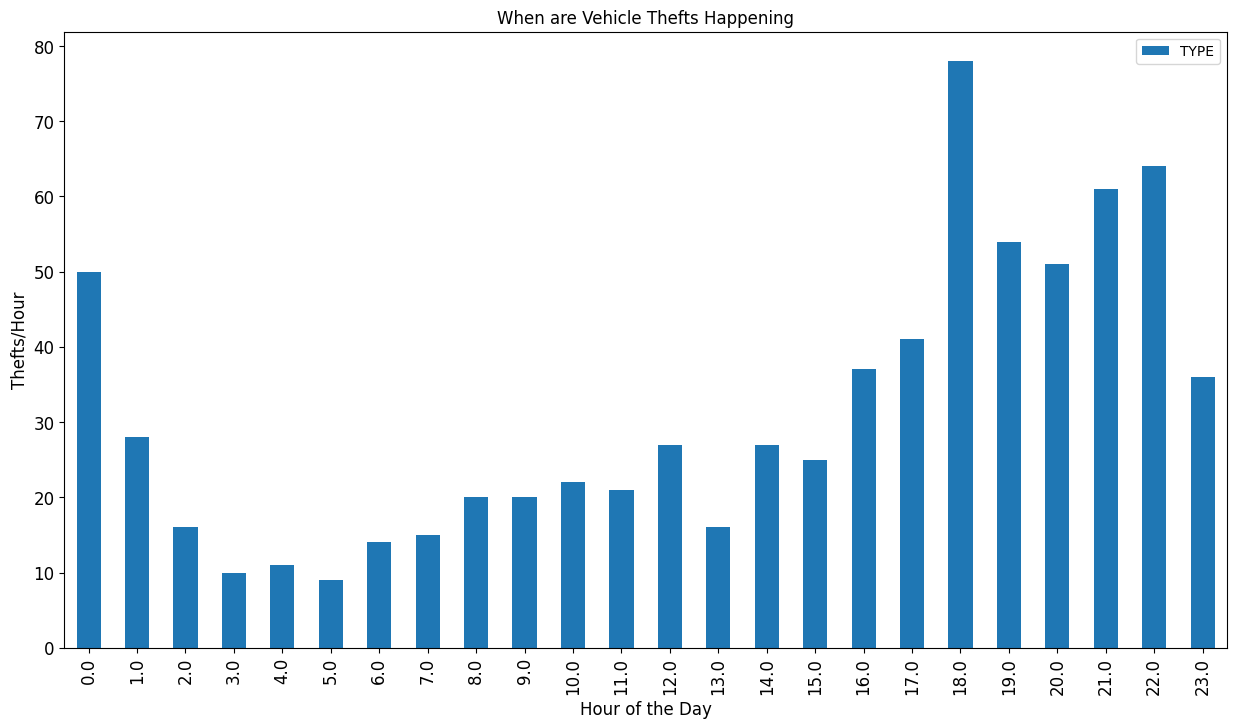

In [ ]:
# Create a dataset of counts per hour
veh_hour = veh2017[['TYPE','HOUR']].groupby(['HOUR'],as_index=False).count()

ax = veh_hour.plot(kind='bar', x='HOUR', title ="When are Vehicle Thefts Happening", figsize=(15, 8), fontsize=12,legend=True,)
ax.set_xlabel("Hour of the Day", fontsize=12)
ax.set_ylabel("Thefts/Hour", fontsize=12)
plt.show()

This code creates a simple map using GeoPandas, overlaying markers representing geographical points (latitude and longitude) of crime incidents onto a world map, facilitating spatial analysis and visualization of crime distribution.

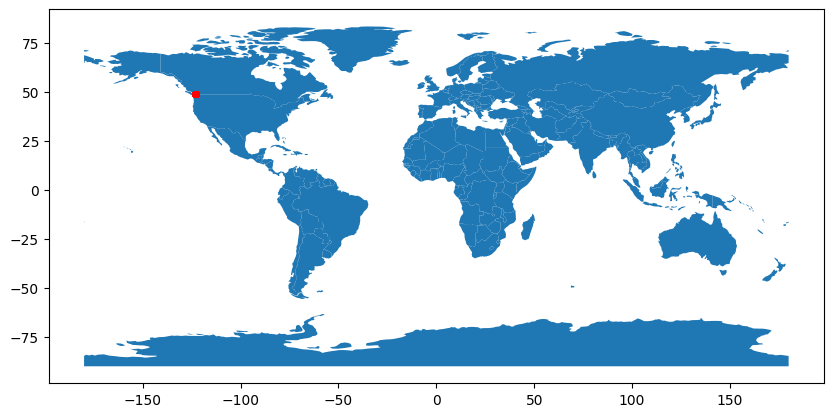

In [ ]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

Zooming in world plot to get detail of data

(49.180897, 49.333349)

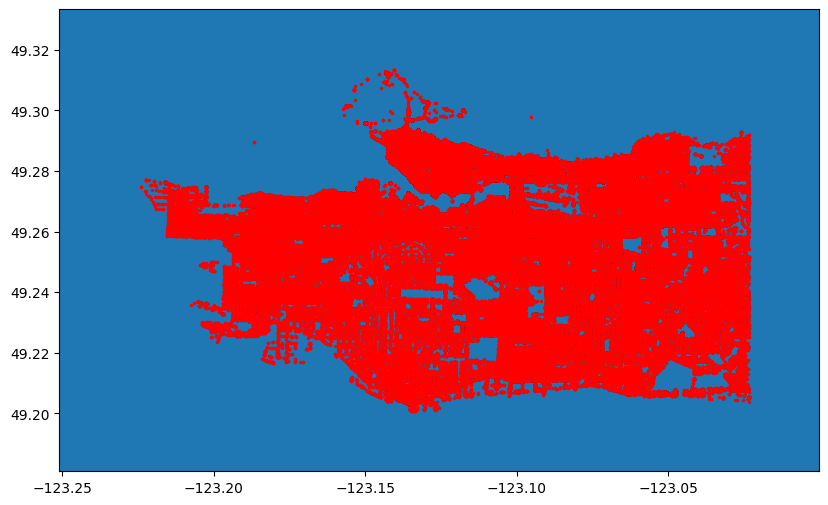

In [ ]:
min_lon = -123.250955
max_lon = -123.000289
min_lat = 49.180897
max_lat = 49.333349

subset_gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6))
subset_gdf.plot(ax=ax, marker='o', color='red', markersize=2)

ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

plotting location with neighbourhood column.

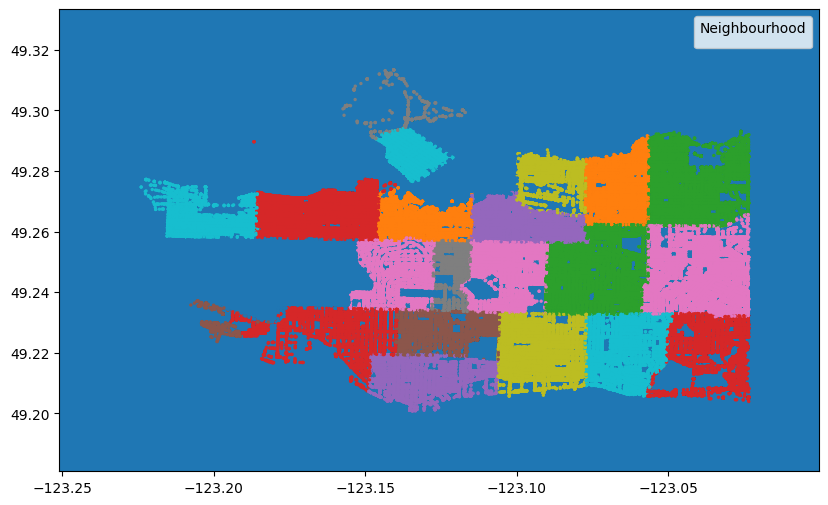

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(figsize=(10, 6))

subset_gdf.plot(ax=ax, column='NEIGHBOURHOOD', marker='o', markersize=2, legend=True)

min_lon, max_lon = -123.250955, -123.000289
min_lat, max_lat = 49.180897, 49.333349
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

ax.legend(title='Neighbourhood')

plt.show()

Utilizes GeoPandas to plot crime incidents on a world map, categorizing them by crime type and assigning a unique color to each category, enabling visual analysis of crime distribution across geographic regions. Additionally, it sets boundaries to focus the map on a specific area of interest, improving readability and interpretation of the plotted data.

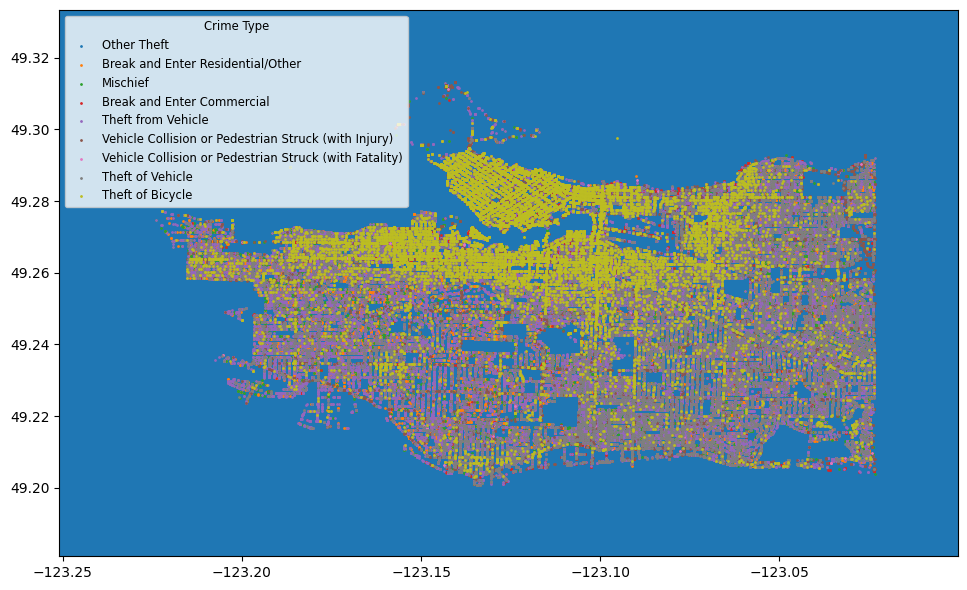

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6))

palette = sns.color_palette("tab10", n_colors=len(subset_gdf['TYPE'].unique()))


for i, crime_type in enumerate(subset_gdf['TYPE'].unique()):
    crime_subset = subset_gdf[subset_gdf['TYPE'] == crime_type]
    crime_subset.plot(ax=ax, marker='o', markersize=1, label=crime_type, color=palette[i])

min_lon, max_lon = -123.250955, -123.000289
min_lat, max_lat = 49.180897, 49.333349
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

ax.legend(title='Crime Type', loc='upper left', fontsize='small', title_fontsize='small')
plt.tight_layout()

# Show the plot
plt.show()


While checking Count of Types of crime using count plot which shows Theft from vehicle occurs most

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Other Theft'),
  Text(1, 0, 'Break and Enter Residential/Other'),
  Text(2, 0, 'Mischief'),
  Text(3, 0, 'Break and Enter Commercial'),
  Text(4, 0, 'Theft from Vehicle'),
  Text(5, 0, 'Vehicle Collision or Pedestrian Struck (with Injury)'),
  Text(6, 0, 'Vehicle Collision or Pedestrian Struck (with Fatality)'),
  Text(7, 0, 'Theft of Vehicle'),
  Text(8, 0, 'Theft of Bicycle')])

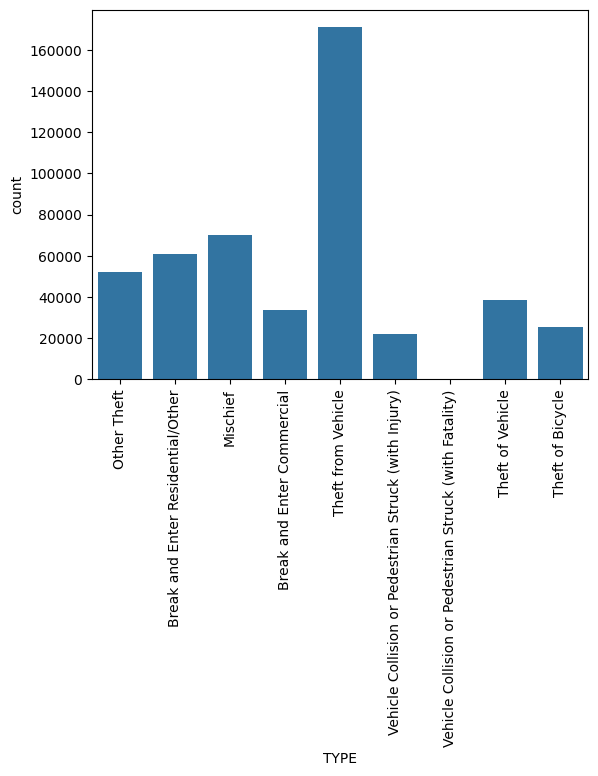

In [ ]:
sns.countplot(x=df.TYPE)
plt.xticks(rotation=90)

Seaborn count plot depicting the distribution of different crime types across various neighborhoods. The x-axis represents the neighborhoods, while the count of each crime type is shown in Y-axis. from the plot its visible that theft from vehicle is high

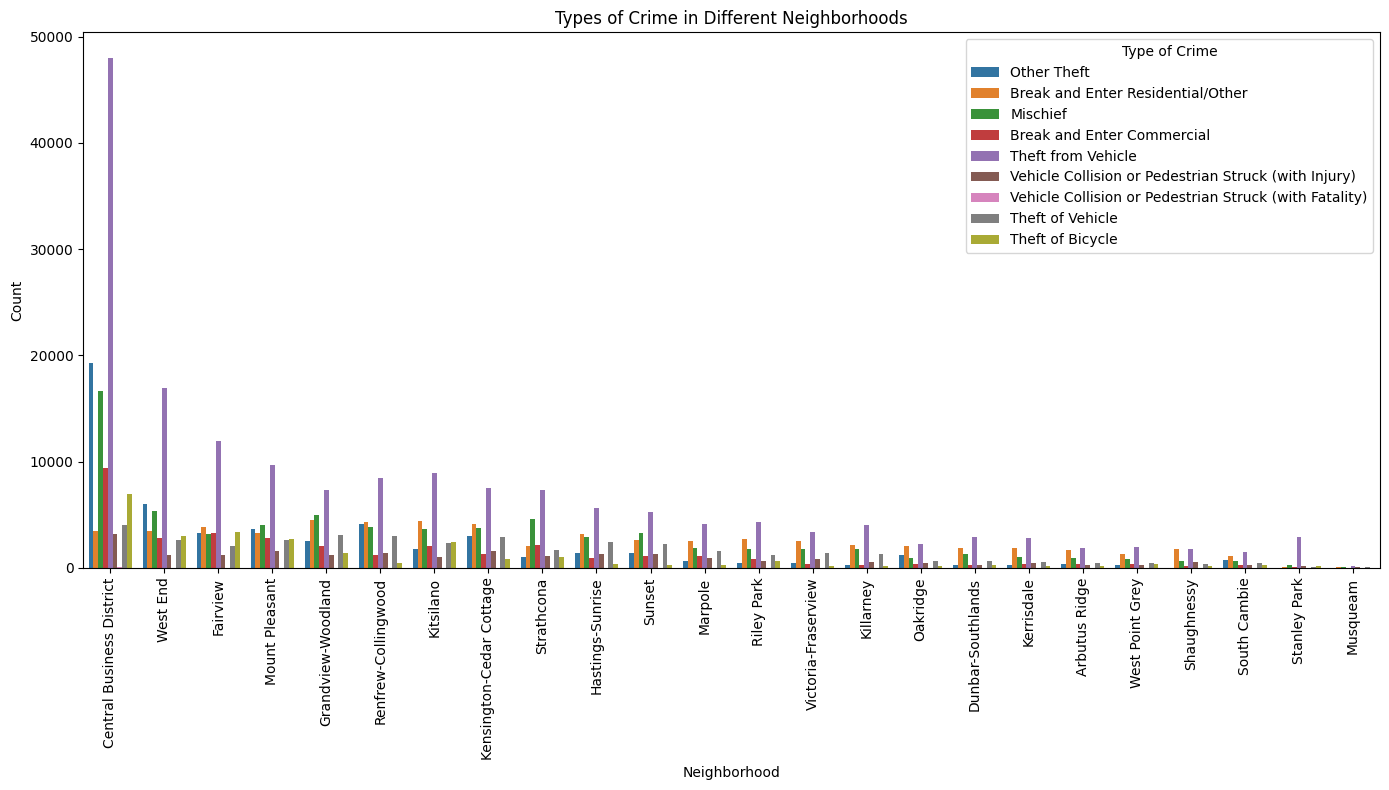

In [ ]:


# Assuming your DataFrame is named df and contains 'NEIGHBOURHOOD' and 'TYPE' columns
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='NEIGHBOURHOOD', hue='TYPE', order=df['NEIGHBOURHOOD'].value_counts().index)
plt.title('Types of Crime in Different Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Type of Crime')
plt.tight_layout()
plt.show()


Extracts the year and type of crime from the 'Date' and 'TYPE' columns, groups the data by year and type of crime, counts the occurrences, and then plots a line graph showing the distribution of different types of crimes over the years. The x-axis represents the years, the y-axis represents the number of crimes, and each line corresponds to a different type of crime.

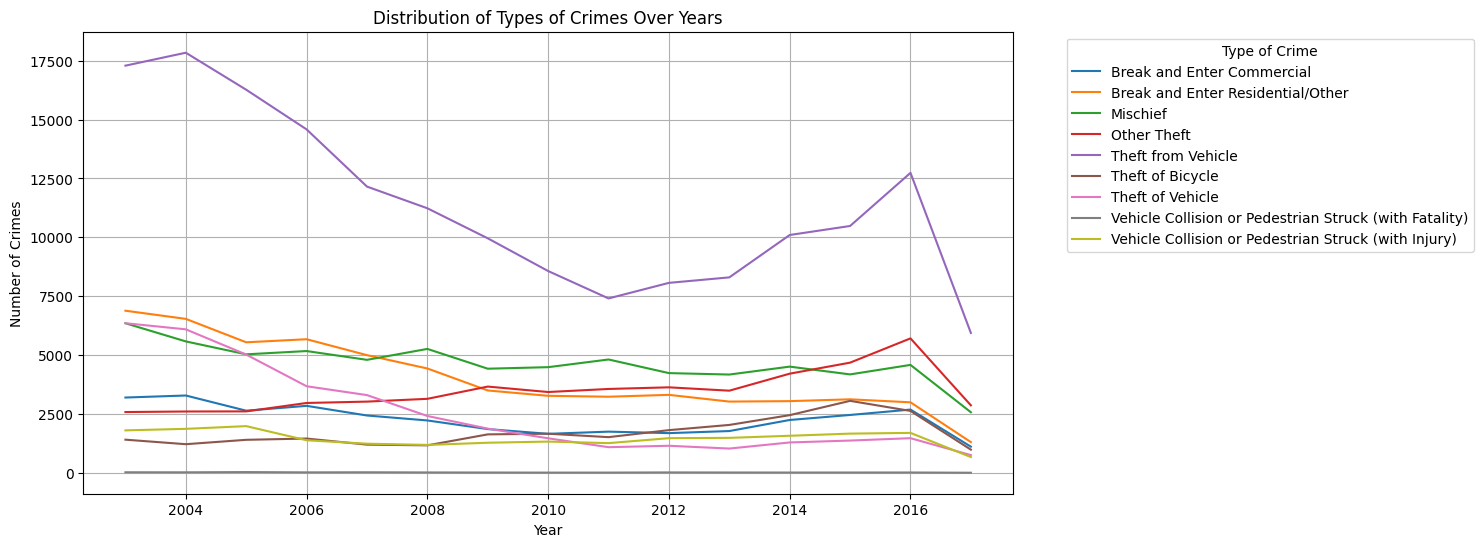

In [ ]:


# Extract year and type of crime from the 'Date' and 'TYPE' columns
subset_gdf['Year'] = subset_gdf['Date'].dt.year

# Group by year and type of crime and count the occurrences
crime_count_by_year = subset_gdf.groupby(['Year', 'TYPE']).size().reset_index(name='Count')

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=crime_count_by_year, x='Year', y='Count', hue='TYPE')
plt.title('Distribution of Types of Crimes Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.legend(title='Type of Crime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


A histogram plot showing the distribution of incidents by hour, with the x-axis representing the hour of the day, the y-axis representing the frequency of incidents, and each bin representing an hour. Additionally, it includes a kernel density estimate (kde) to visualize the underlying distribution of the data more smoothly.

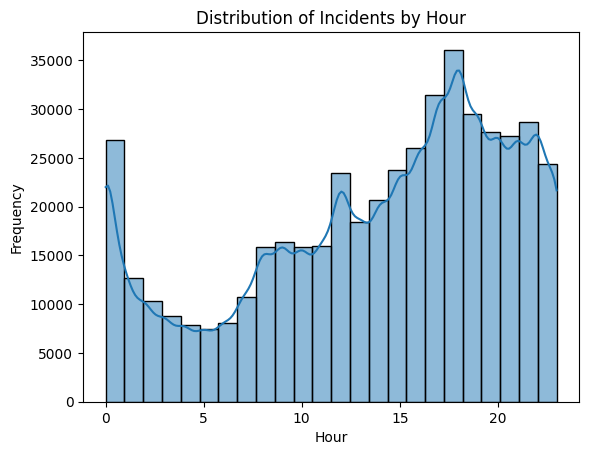

In [ ]:
sns.histplot(df.HOUR, bins=24, kde=True)
plt.title('Distribution of Incidents by Hour')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

A bar plot illustrating the distribution of incidents by month. The x-axis represents the months, and the y-axis represents the frequency of incidents. The height of each bar indicates the number of incidents that occurred in each month.

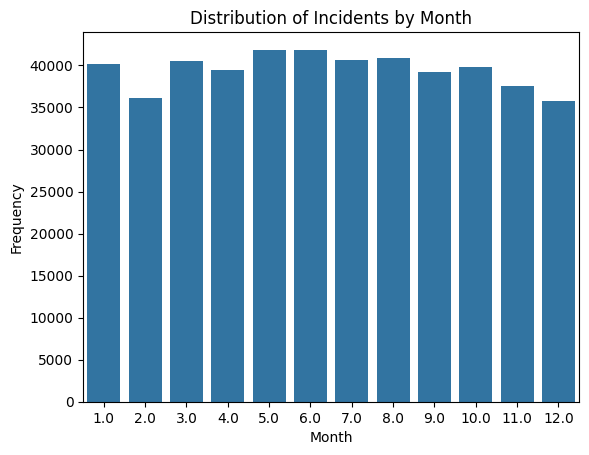

In [ ]:

# Assuming df contains the DataFrame with the 'MONTH' column
sns.barplot(x=df['MONTH'].value_counts().index, y=df['MONTH'].value_counts())
plt.title('Distribution of Incidents by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()


Converts separate date and time components into a single datetime column, aggregates crime counts by date, and plots the resulting time series to visualize the distribution of crimes over time.

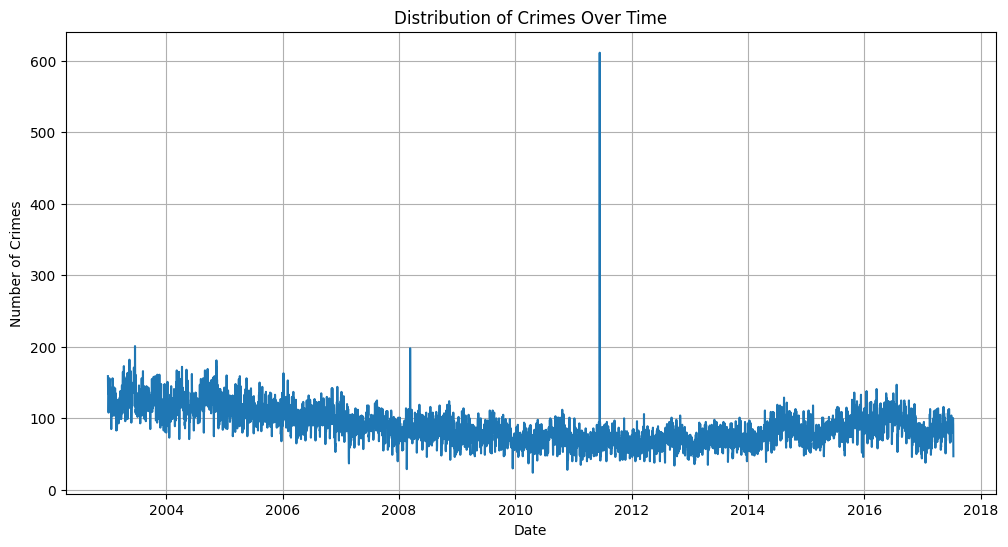

In [ ]:
subset_gdf['Date'] = pd.to_datetime(subset_gdf[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE']])

crime_count_by_date = subset_gdf.groupby(subset_gdf['Date'].dt.date).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=crime_count_by_date, x='Date', y='Count')
plt.title('Distribution of Crimes Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.show()


A pie chart to display the proportion of different incident types within the dataset, with percentage labels for each slice and a title indicating "Proportion of Incidents by Type".

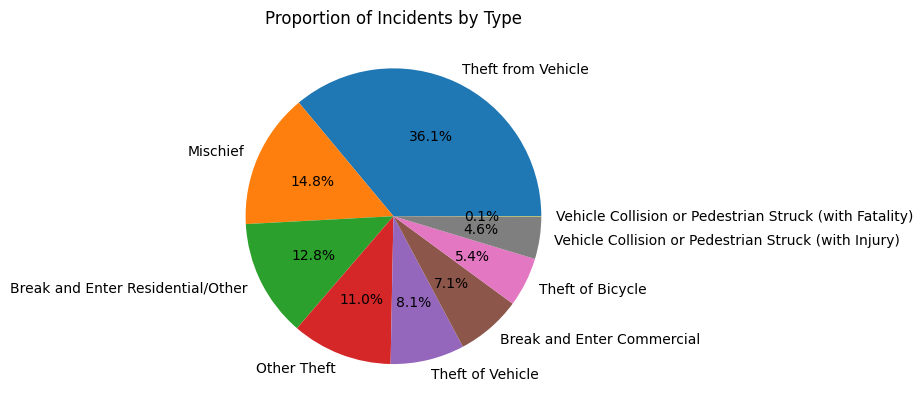

In [ ]:
df['TYPE'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Proportion of Incidents by Type')
plt.ylabel('')
plt.show()

A heatmap is a data visualization technique that uses color to represent the values of a matrix. Checking correlation between columns using heatmap

<Axes: >

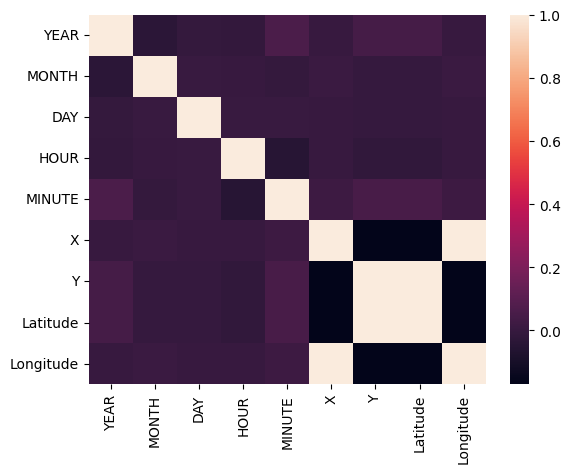

In [ ]:
numerical_cols = df.select_dtypes(include=['int', 'float'])
sns.heatmap(numerical_cols.corr())

droping unneeded columns for training

In [ ]:
df = df.drop(['YEAR', 'Date'], axis=1)

In [ ]:
df

,TYPE,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,Other Theft,5.0,12.0,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
1,Other Theft,5.0,7.0,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
2,Other Theft,4.0,23.0,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
3,Other Theft,4.0,20.0,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
4,Other Theft,4.0,12.0,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
...,...,...,...,...,...,...,...,...,...,...,...
530646,Mischief,1.0,18.0,14.0,44.0,14XX E HASTINGS ST,Grandview-Woodland,494563.75,5458727.40,49.281276,-123.074746
530647,Break and Enter Residential/Other,3.0,3.0,9.0,16.0,31XX ADANAC ST,Hastings-Sunrise,497265.49,5458296.71,49.277420,-123.037595
530648,Mischief,5.0,29.0,22.0,30.0,14XX E 7TH AVE,Grandview-Woodland,494533.97,5456824.97,49.264163,-123.075129
530650,Theft from Vehicle,6.0,5.0,17.0,0.0,8XX HAMILTON ST,Central Business District,491487.85,5458385.78,49.278168,-123.117031


In [ ]:
x = df.copy()

In [ ]:
y = x.pop("TYPE")

## **OverSampling**

To solve the issue of class inbalance. we are using RandomOverSampler to fix the issue

In [ ]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(x, y)

balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=x.columns),
                         pd.DataFrame(y_resampled, columns=['TYPE'])],
                        axis=1)

# Check the class distribution after balancing
print(balanced_df['TYPE'].value_counts())

TYPE
Other Theft                                               170889
Break and Enter Residential/Other                         170889
Mischief                                                  170889
Break and Enter Commercial                                170889
Theft from Vehicle                                        170889
Vehicle Collision or Pedestrian Struck (with Injury)      170889
Vehicle Collision or Pedestrian Struck (with Fatality)    170889
Theft of Vehicle                                          170889
Theft of Bicycle                                          170889
Name: count, dtype: int64


In [ ]:
# balanced_df = balanced_df[:100000]

In [ ]:
x = balanced_df.copy()
y = x.pop("TYPE")

In [ ]:
y

0                                                Other Theft
1                                                Other Theft
2                                                Other Theft
3                                                Other Theft
4                                                Other Theft
                                 ...                        
1537996    Vehicle Collision or Pedestrian Struck (with I...
1537997    Vehicle Collision or Pedestrian Struck (with I...
1537998    Vehicle Collision or Pedestrian Struck (with I...
1537999    Vehicle Collision or Pedestrian Struck (with I...
1538000    Vehicle Collision or Pedestrian Struck (with I...
Name: TYPE, Length: 1538001, dtype: object

In [ ]:
x

,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,5.0,12.0,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
1,5.0,7.0,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
2,4.0,23.0,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
3,4.0,20.0,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
4,4.0,12.0,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
...,...,...,...,...,...,...,...,...,...,...
1537996,8.0,21.0,19.0,30.0,11XX BLOCK ROBSON ST,West End,490895.0,5459127.00,49.284827,-123.125198
1537997,7.0,15.0,15.0,48.0,15XX BLOCK E 49TH AVE,Victoria-Fraserview,494622.0,5452475.00,49.225035,-123.073861
1537998,6.0,26.0,9.0,32.0,BURRARD ST / PACIFIC ST,West End,490369.0,5458252.00,49.276948,-123.132410
1537999,11.0,24.0,18.0,15.0,FRASER ST / E 14TH AVE,Mount Pleasant,493508.0,5456134.00,49.257938,-123.089220


In [ ]:
x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [ ]:
columns_to_encode = ["NEIGHBOURHOOD"]
columns_to_scale = ["X", "Y", "Latitude", "Longitude"]
columns_to_label_encode = ["HUNDRED_BLOCK"]

In [ ]:
len(list(x.HUNDRED_BLOCK.value_counts()))

21192

## **Scaling**

Scaling Numerical columns between -1 and 1.

In [ ]:
scaler = StandardScaler()

scaler.fit(x[columns_to_scale])

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
x[columns_to_scale]=scaler.transform(x[columns_to_scale])


In [ ]:
x

,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,5.0,12.0,16.0,15.0,9XX TERMINAL AVE,Strathcona,0.578110,0.359321,0.360447,0.577776
1,5.0,7.0,15.0,20.0,9XX TERMINAL AVE,Strathcona,0.578110,0.359321,0.360447,0.577776
2,4.0,23.0,16.0,40.0,9XX TERMINAL AVE,Strathcona,0.578110,0.359321,0.360447,0.577776
3,4.0,20.0,11.0,15.0,9XX TERMINAL AVE,Strathcona,0.578110,0.359321,0.360447,0.577776
4,4.0,12.0,17.0,45.0,9XX TERMINAL AVE,Strathcona,0.578110,0.359321,0.360447,0.577776
...,...,...,...,...,...,...,...,...,...,...
1537996,8.0,21.0,19.0,30.0,11XX BLOCK ROBSON ST,West End,-0.508385,1.020306,1.019890,-0.509824
1537997,7.0,15.0,15.0,48.0,15XX BLOCK E 49TH AVE,Victoria-Fraserview,0.836249,-1.605429,-1.604320,0.837694
1537998,6.0,26.0,9.0,32.0,BURRARD ST / PACIFIC ST,West End,-0.698156,0.674918,0.674096,-0.699116
1537999,11.0,24.0,18.0,15.0,FRASER ST / E 14TH AVE,Mount Pleasant,0.434338,-0.161117,-0.160251,0.434553


## **Encoding**
Encoding categorical column using onehot encoding

In [ ]:
encoder = OneHotEncoder(sparse=False)

encoded = encoder.fit_transform(x[["NEIGHBOURHOOD"]])

with open('onehotencoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

one_hot_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['NEIGHBOURHOOD']))
x = pd.concat([x, one_hot_df], axis=1)

x.drop('NEIGHBOURHOOD', axis=1, inplace=True)



In [ ]:
x

,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,X,Y,Latitude,Longitude,NEIGHBOURHOOD_Arbutus Ridge,...,NEIGHBOURHOOD_Renfrew-Collingwood,NEIGHBOURHOOD_Riley Park,NEIGHBOURHOOD_Shaughnessy,NEIGHBOURHOOD_South Cambie,NEIGHBOURHOOD_Stanley Park,NEIGHBOURHOOD_Strathcona,NEIGHBOURHOOD_Sunset,NEIGHBOURHOOD_Victoria-Fraserview,NEIGHBOURHOOD_West End,NEIGHBOURHOOD_West Point Grey
0,5.0,12.0,16.0,15.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,5.0,7.0,15.0,20.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.0,23.0,16.0,40.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.0,20.0,11.0,15.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,12.0,17.0,45.0,9XX TERMINAL AVE,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537996,8.0,21.0,19.0,30.0,11XX BLOCK ROBSON ST,-0.508385,1.020306,1.019890,-0.509824,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1537997,7.0,15.0,15.0,48.0,15XX BLOCK E 49TH AVE,0.836249,-1.605429,-1.604320,0.837694,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1537998,6.0,26.0,9.0,32.0,BURRARD ST / PACIFIC ST,-0.698156,0.674918,0.674096,-0.699116,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1537999,11.0,24.0,18.0,15.0,FRASER ST / E 14TH AVE,0.434338,-0.161117,-0.160251,0.434553,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x.columns

Index(['MONTH', 'DAY', 'HOUR', 'MINUTE', 'HUNDRED_BLOCK', 'X', 'Y', 'Latitude',
       'Longitude', 'NEIGHBOURHOOD_Arbutus Ridge',
       'NEIGHBOURHOOD_Central Business District',
       'NEIGHBOURHOOD_Dunbar-Southlands', 'NEIGHBOURHOOD_Fairview',
       'NEIGHBOURHOOD_Grandview-Woodland', 'NEIGHBOURHOOD_Hastings-Sunrise',
       'NEIGHBOURHOOD_Kensington-Cedar Cottage', 'NEIGHBOURHOOD_Kerrisdale',
       'NEIGHBOURHOOD_Killarney', 'NEIGHBOURHOOD_Kitsilano',
       'NEIGHBOURHOOD_Marpole', 'NEIGHBOURHOOD_Mount Pleasant',
       'NEIGHBOURHOOD_Musqueam', 'NEIGHBOURHOOD_Oakridge',
       'NEIGHBOURHOOD_Renfrew-Collingwood', 'NEIGHBOURHOOD_Riley Park',
       'NEIGHBOURHOOD_Shaughnessy', 'NEIGHBOURHOOD_South Cambie',
       'NEIGHBOURHOOD_Stanley Park', 'NEIGHBOURHOOD_Strathcona',
       'NEIGHBOURHOOD_Sunset', 'NEIGHBOURHOOD_Victoria-Fraserview',
       'NEIGHBOURHOOD_West End', 'NEIGHBOURHOOD_West Point Grey'],
      dtype='object')

doing label encoding to HUNDRED_BLOCK column to assign number to each category

In [ ]:
label_encoder = LabelEncoder()

x['HUNDRED_BLOCK'] = label_encoder.fit_transform(x['HUNDRED_BLOCK'])

with open('labelencoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [ ]:
x

,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,X,Y,Latitude,Longitude,NEIGHBOURHOOD_Arbutus Ridge,...,NEIGHBOURHOOD_Renfrew-Collingwood,NEIGHBOURHOOD_Riley Park,NEIGHBOURHOOD_Shaughnessy,NEIGHBOURHOOD_South Cambie,NEIGHBOURHOOD_Stanley Park,NEIGHBOURHOOD_Strathcona,NEIGHBOURHOOD_Sunset,NEIGHBOURHOOD_Victoria-Fraserview,NEIGHBOURHOOD_West End,NEIGHBOURHOOD_West Point Grey
0,5.0,12.0,16.0,15.0,14366,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,5.0,7.0,15.0,20.0,14366,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.0,23.0,16.0,40.0,14366,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.0,20.0,11.0,15.0,14366,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,12.0,17.0,45.0,14366,0.578110,0.359321,0.360447,0.577776,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537996,8.0,21.0,19.0,30.0,359,-0.508385,1.020306,1.019890,-0.509824,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1537997,7.0,15.0,15.0,48.0,1417,0.836249,-1.605429,-1.604320,0.837694,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1537998,6.0,26.0,9.0,32.0,15076,-0.698156,0.674918,0.674096,-0.699116,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1537999,11.0,24.0,18.0,15.0,17550,0.434338,-0.161117,-0.160251,0.434553,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x["HUNDRED_BLOCK"] = x["HUNDRED_BLOCK"].astype(float)

Label Encoding target variable Y

In [ ]:
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

with open('labelencoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [ ]:
y

array([3, 3, 3, ..., 8, 8, 8])

## **Training**

 Splitting data in to training and testing

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(1230400, 33)
(1230400,)
(307601, 33)
(307601,)


## Training on Decision Tree Classifier

In [ ]:
%%time
dt_model = DecisionTreeClassifier()
dt_model.fit(xtrain, ytrain)

# Make predictions
dt_ypred = dt_model.predict(xtest)

# Calculate evaluation metrics
dt_accuracy = accuracy_score(ytest, dt_ypred)
dt_precision = precision_score(ytest, dt_ypred, average='weighted')
dt_recall = recall_score(ytest, dt_ypred, average='weighted')
dt_f1 = f1_score(ytest, dt_ypred, average='weighted')

# Print evaluation metrics
print("Decision Tree - Accuracy:", dt_accuracy)
print("Decision Tree - Precision:", dt_precision)
print("Decision Tree - Recall:", dt_recall)
print("Decision Tree - F1 Score:", dt_f1)

Decision Tree - Accuracy: 0.9024515524982039
Decision Tree - Precision: 0.8991979596032988
Decision Tree - Recall: 0.9024515524982039
Decision Tree - F1 Score: 0.8938515294110563
CPU times: user 26.6 s, sys: 983 ms, total: 27.6 s
Wall time: 30.9 s


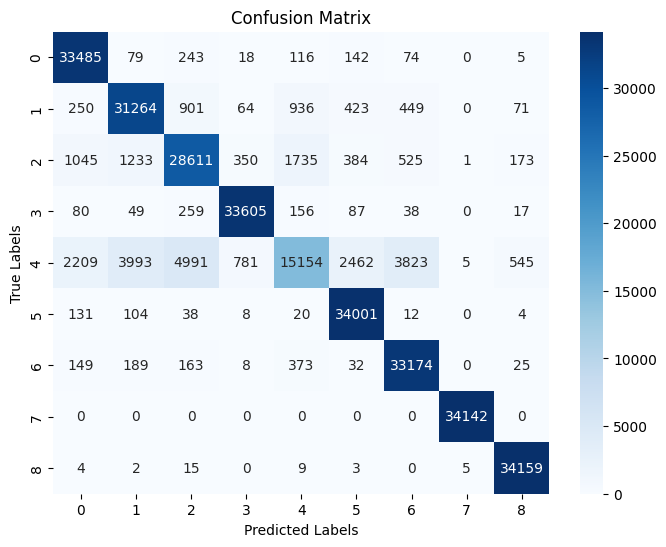

In [ ]:

# Calculate confusion matrix
cm = confusion_matrix(ytest, dt_ypred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



## Training on Random Forest classifier

In [ ]:
%%time
rf_model = RandomForestClassifier()
rf_model.fit(xtrain, ytrain)

# Make predictions
rf_ypred = rf_model.predict(xtest)

# Calculate evaluation metrics
rf_accuracy = accuracy_score(ytest, rf_ypred)
rf_precision = precision_score(ytest, rf_ypred, average='weighted')
rf_recall = recall_score(ytest, rf_ypred, average='weighted')
rf_f1 = f1_score(ytest, rf_ypred, average='weighted')

# Print evaluation metrics
print("Random Forest - Accuracy:", rf_accuracy)
print("Random Forest - Precision:", rf_precision)
print("Random Forest - Recall:", rf_recall)
print("Random Forest - F1 Score:", rf_f1)

Random Forest - Accuracy: 0.9184560518333815
Random Forest - Precision: 0.9163078482591989
Random Forest - Recall: 0.9184560518333815
Random Forest - F1 Score: 0.9135147958357013
CPU times: user 8min 17s, sys: 5.68 s, total: 8min 22s
Wall time: 8min 27s


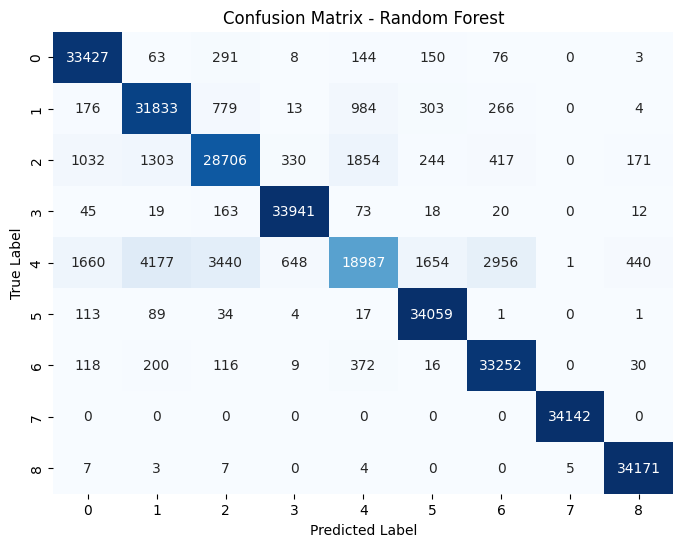

In [ ]:


# Compute confusion matrix
cm = confusion_matrix(ytest, rf_ypred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Training on Logistic Regression

In [ ]:
%%time
lr_model = LogisticRegression()
lr_model.fit(xtrain, ytrain)

# Make predictions
lr_ypred = lr_model.predict(xtest)

# Calculate evaluation metrics
lr_accuracy = accuracy_score(ytest, lr_ypred)
lr_precision = precision_score(ytest, lr_ypred, average='weighted')
lr_recall = recall_score(ytest, lr_ypred, average='weighted')
lr_f1 = f1_score(ytest, lr_ypred, average='weighted')

# Print evaluation metrics
print("Logistic Regression - Accuracy:", lr_accuracy)
print("Logistic Regression - Precision:", lr_precision)
print("Logistic Regression - Recall:", lr_recall)
print("Logistic Regression - F1 Score:", lr_f1)

Logistic Regression - Accuracy: 0.2036989476627189
Logistic Regression - Precision: 0.1922940719516476
Logistic Regression - Recall: 0.2036989476627189
Logistic Regression - F1 Score: 0.16224335764549289
CPU times: user 1min 15s, sys: 20.2 s, total: 1min 35s
Wall time: 1min 6s


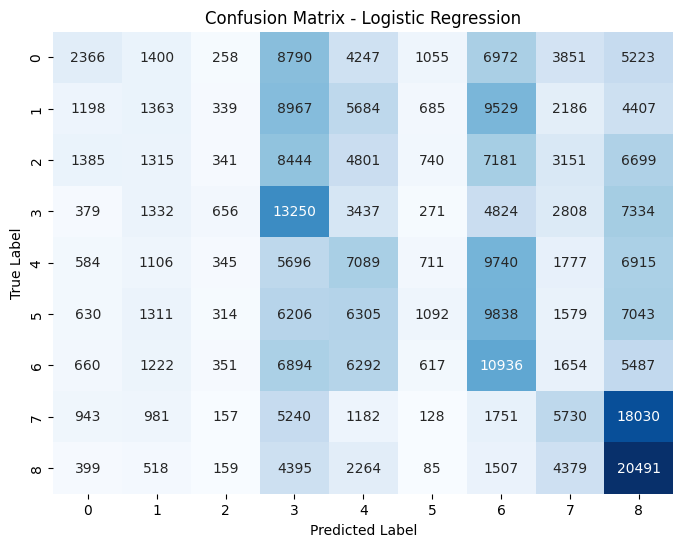

In [ ]:
# Compute confusion matrix
cm_lr = confusion_matrix(ytest, lr_ypred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [ ]:
xtrain = xtrain[:100000]
ytrain = ytrain[:100000]
xtest = xtest[:20000]
ytest = ytest[:20000]

## Training of K Nearest Neighbour

In [ ]:
%%time
knn_model = KNeighborsClassifier()
knn_model.fit(xtrain, ytrain)

# Make predictions
knn_ypred = knn_model.predict(xtest)

# Calculate evaluation metrics
knn_accuracy = accuracy_score(ytest, knn_ypred)
knn_precision = precision_score(ytest, knn_ypred, average='weighted')
knn_recall = recall_score(ytest, knn_ypred, average='weighted')
knn_f1 = f1_score(ytest, knn_ypred, average='weighted')

# Print evaluation metrics
print("K Nearest Neighbors - Accuracy:", knn_accuracy)
print("K Nearest Neighbors - Precision:", knn_precision)
print("K Nearest Neighbors - Recall:", knn_recall)
print("K Nearest Neighbors - F1 Score:", knn_f1)

K Nearest Neighbors - Accuracy: 0.45625
K Nearest Neighbors - Precision: 0.44388980092686386
K Nearest Neighbors - Recall: 0.45625
K Nearest Neighbors - F1 Score: 0.4471354990372075
CPU times: user 21.4 s, sys: 121 ms, total: 21.5 s
Wall time: 14.1 s


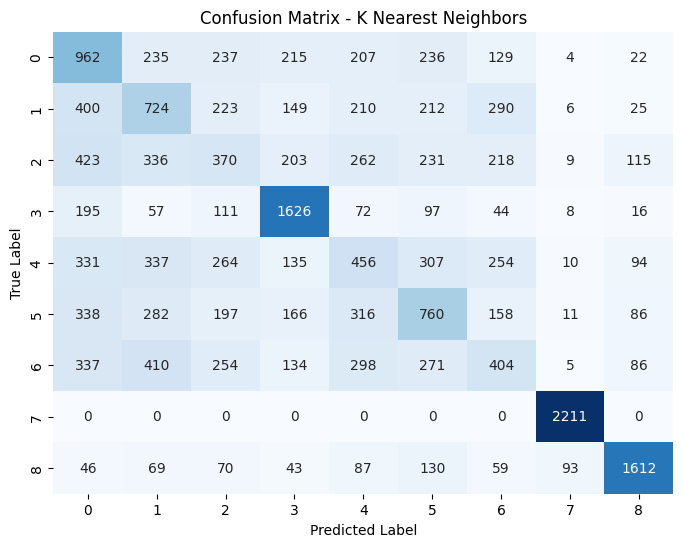

In [ ]:
# Compute confusion matrix
cm_knn = confusion_matrix(ytest, knn_ypred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - K Nearest Neighbors')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
x = x[:10000]
y = y[:10000]

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [ ]:
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

In [ ]:
ytrain

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

## Architecture of Neural Network

Epoch 1/50
200/200 [==============================] - 3s 7ms/step - loss: 1.2465 - accuracy: 0.5306 - val_loss: 1.7258 - val_accuracy: 0.3300
Epoch 2/50
200/200 [==============================] - 1s 6ms/step - loss: 1.1310 - accuracy: 0.5608 - val_loss: 2.7341 - val_accuracy: 0.2338
Epoch 3/50
200/200 [==============================] - 1s 6ms/step - loss: 1.1373 - accuracy: 0.5539 - val_loss: 2.6226 - val_accuracy: 0.3262
Epoch 4/50
200/200 [==============================] - 1s 7ms/step - loss: 1.1004 - accuracy: 0.5683 - val_loss: 6.9995 - val_accuracy: 0.2587
Epoch 5/50
200/200 [==============================] - 2s 9ms/step - loss: 1.0714 - accuracy: 0.5672 - val_loss: 37.0569 - val_accuracy: 0.1838
Epoch 6/50
200/200 [==============================] - 2s 10ms/step - loss: 1.1014 - accuracy: 0.5713 - val_loss: 2.3543 - val_accuracy: 0.2062
Epoch 7/50
200/200 [==============================] - 1s 6ms/step - loss: 1.1059 - accuracy: 0.5620 - val_loss: 4.3509 - val_accuracy: 0.1800
Epoc

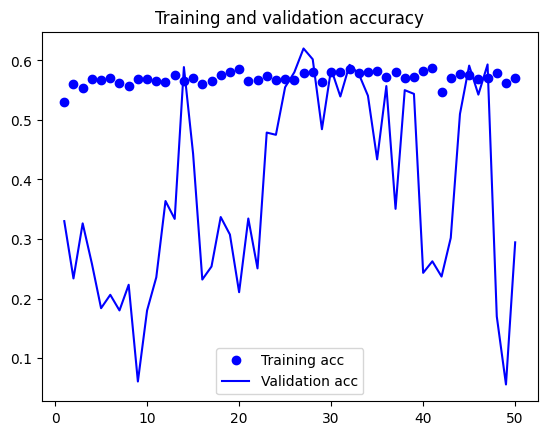

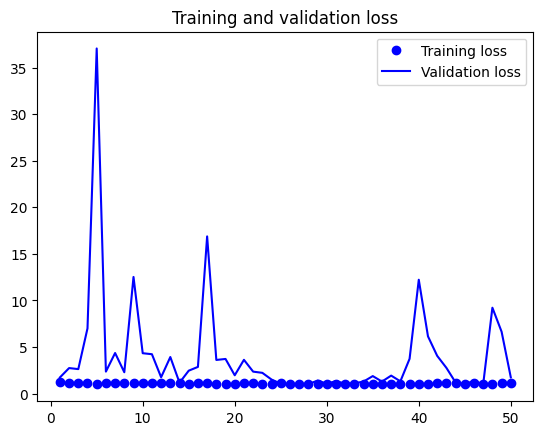

In [ ]:
from keras import backend as K

model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(xtrain.shape[1],)))
# Hidden layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())  # Add batch normalization
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())  # Add batch normalization
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(9, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(xtrain, ytrain, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(xtest, ytest, verbose=0)

# Make predictions
y_pred = model.predict(xtest)

# Calculate precision, recall, and F1-score
true_positives = K.sum(K.round(K.clip(ytest * y_pred, 0, 1)))
predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
possible_positives = K.sum(K.round(K.clip(ytest, 0, 1)))

precision_val = true_positives / (predicted_positives + K.epsilon())
recall_val = true_positives / (possible_positives + K.epsilon())
f1_val = 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))

# Convert precision, recall, and F1-score to NumPy arrays
precision_val = precision_val.numpy()
recall_val = recall_val.numpy()
f1_val = f1_val.numpy()

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision_val)
print("Recall:", recall_val)
print("F1 Score:", f1_val)


63/63 [==============================] - 0s 2ms/step
Accuracy: 0.28299999237060547
Precision: 0.47782004
Recall: 0.1885
F1 Score: 0.27034774


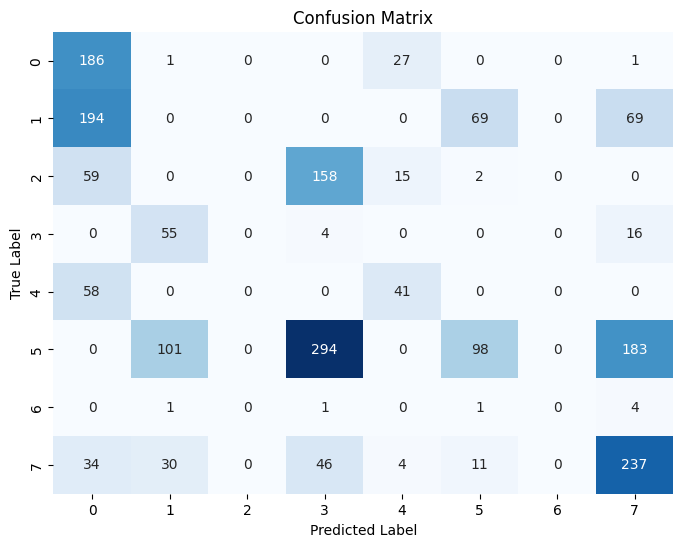

In [ ]:
from sklearn.metrics import confusion_matrix

# Convert one-hot encoded predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_true_classes = np.argmax(ytest, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Recurrent Neural Network

Epoch 1/50
200/200 [==============================] - 5s 17ms/step - loss: 1.7947 - accuracy: 0.3391 - val_loss: 1.7684 - val_accuracy: 0.3250
Epoch 2/50
200/200 [==============================] - 4s 20ms/step - loss: 1.7568 - accuracy: 0.3461 - val_loss: 1.7727 - val_accuracy: 0.3250
Epoch 3/50
200/200 [==============================] - 3s 16ms/step - loss: 1.7550 - accuracy: 0.3461 - val_loss: 1.7726 - val_accuracy: 0.3250
Epoch 4/50
200/200 [==============================] - 3s 15ms/step - loss: 1.7502 - accuracy: 0.3461 - val_loss: 1.7720 - val_accuracy: 0.3250
Epoch 5/50
200/200 [==============================] - 3s 14ms/step - loss: 1.7431 - accuracy: 0.3461 - val_loss: 1.7505 - val_accuracy: 0.3250
Epoch 6/50
200/200 [==============================] - 4s 18ms/step - loss: 1.7256 - accuracy: 0.3562 - val_loss: 1.7297 - val_accuracy: 0.3275
Epoch 7/50
200/200 [==============================] - 4s 20ms/step - loss: 1.7081 - accuracy: 0.3595 - val_loss: 1.7244 - val_accuracy: 0.3275

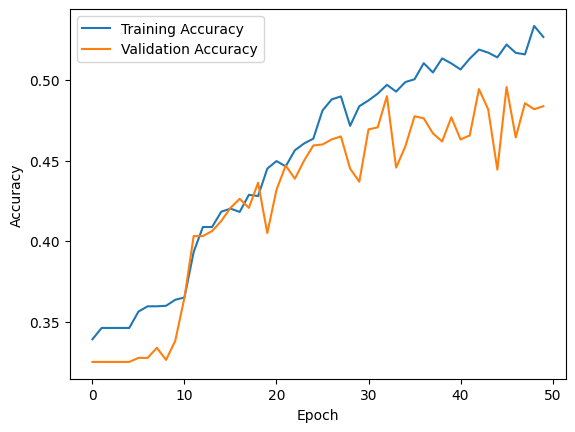

In [ ]:
from tensorflow.keras.layers import LSTM

# Define RNN model
rnn_model = Sequential([
    LSTM(64, input_shape=(xtrain.shape[1], 1)),
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_rnn = rnn_model.fit(xtrain.values.reshape(xtrain.shape[0], xtrain.shape[1], 1), ytrain, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Plot training history
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from keras import backend as K

# Define custom precision metric
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Define custom recall metric
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Define custom F1-score metric
def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))

# Compile the model with custom metrics
rnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1_score])


In [ ]:
# Evaluate the RNN model on test data
rnn_scores = rnn_model.evaluate(xtest.values.reshape(xtest.shape[0], xtest.shape[1], 1), ytest, verbose=0)

# Extract metrics from scores
rnn_accuracy = rnn_scores[1]
rnn_precision = rnn_scores[2]
rnn_recall = rnn_scores[3]
rnn_f1 = rnn_scores[4]

# Print evaluation metrics
print("RNN - Accuracy:", rnn_accuracy)
print("RNN - Precision:", rnn_precision)
print("RNN - Recall:", rnn_recall)
print("RNN - F1 Score:", rnn_f1)


RNN - Accuracy: 0.5070000290870667
RNN - Precision: 0.6265507936477661
RNN - Recall: 0.3075396716594696
RNN - F1 Score: 0.4100622236728668


63/63 [==============================] - 1s 6ms/step


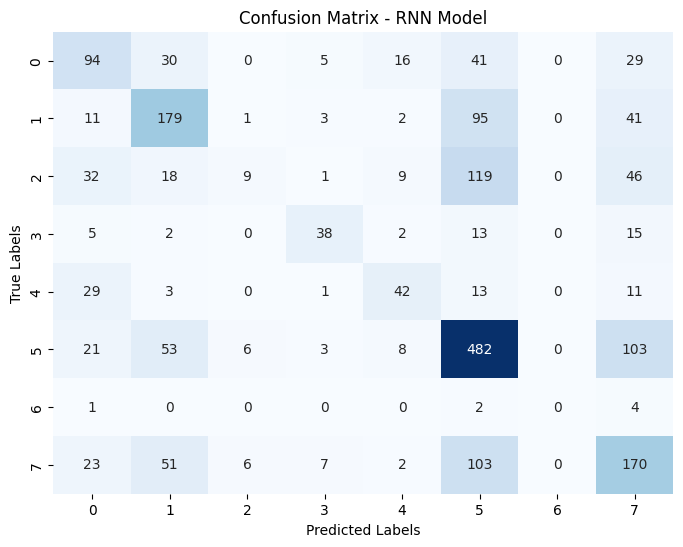

In [ ]:
# Make predictions
rnn_ypred_prob = rnn_model.predict(xtest.values.reshape(xtest.shape[0], xtest.shape[1], 1))

# Convert probability scores to class labels
rnn_ypred = np.argmax(rnn_ypred_prob, axis=1)

# Convert one-hot encoded labels to integer labels
ytest_int = np.argmax(ytest, axis=1)

# Compute confusion matrix
cm_rnn = confusion_matrix(ytest_int, rnn_ypred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - RNN Model')
plt.show()


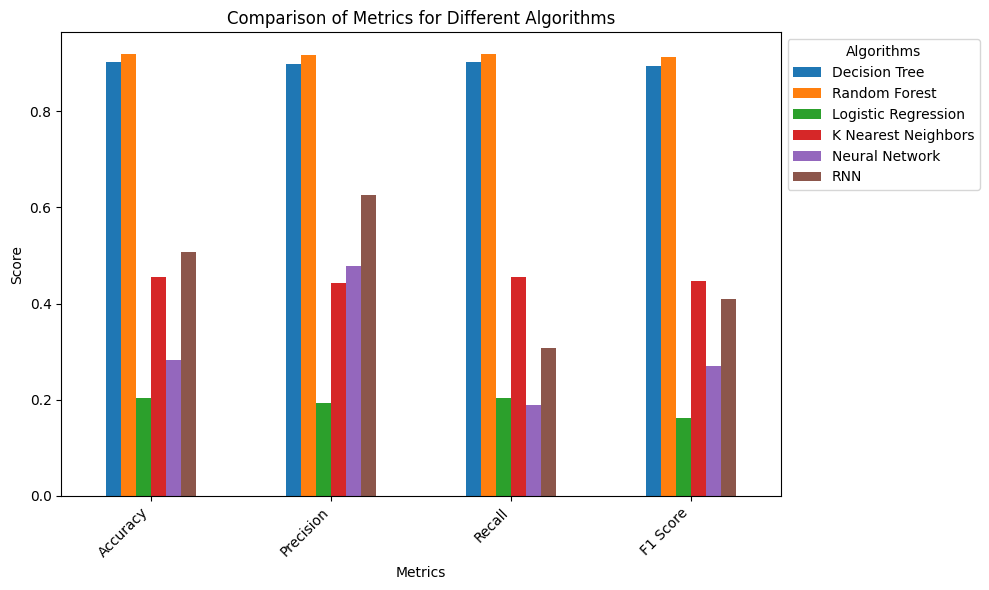

In [ ]:
# Define the metrics for each algorithm
metrics = {
    'Decision Tree': [dt_accuracy, dt_precision, dt_recall, dt_f1],
    'Random Forest': [rf_accuracy, rf_precision, rf_recall, rf_f1],
    'Logistic Regression': [lr_accuracy, lr_precision, lr_recall, lr_f1],
    'K Nearest Neighbors': [knn_accuracy, knn_precision, knn_recall, knn_f1],
    'Neural Network': [accuracy, precision_val, recall_val, f1_val],
    'RNN': [rnn_accuracy, rnn_precision, rnn_recall, rnn_f1]
}

# Define the metrics labels
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame(metrics, index=metric_labels)

# Plot the comparison
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Metrics for Different Algorithms')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Algorithms', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


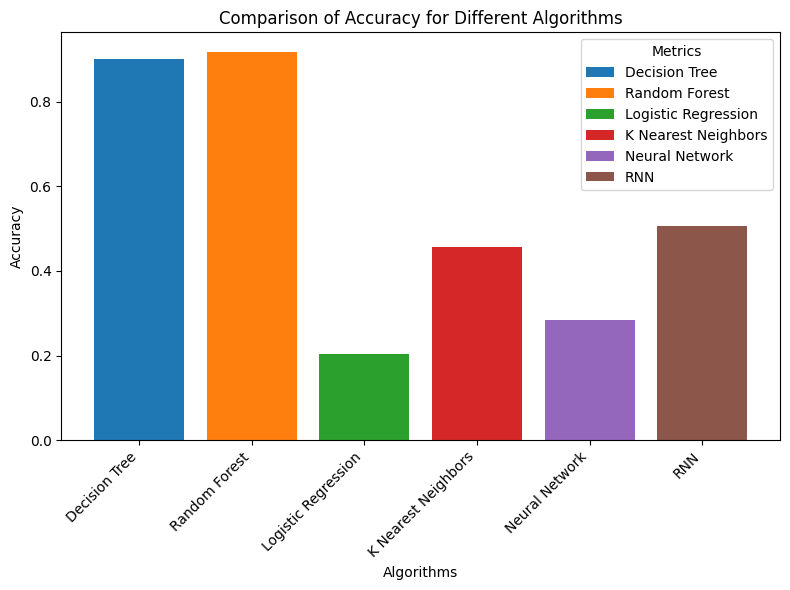

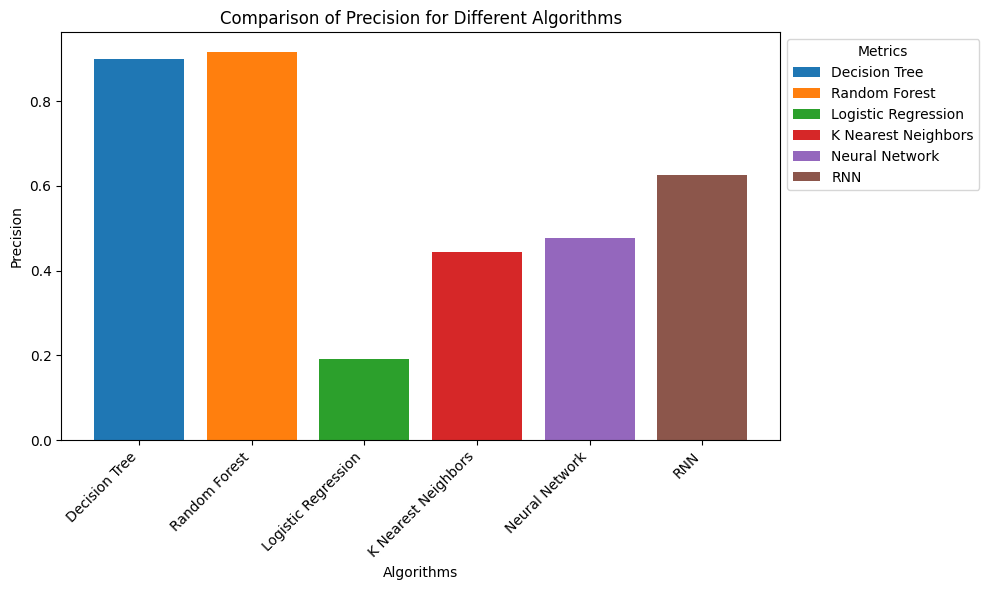

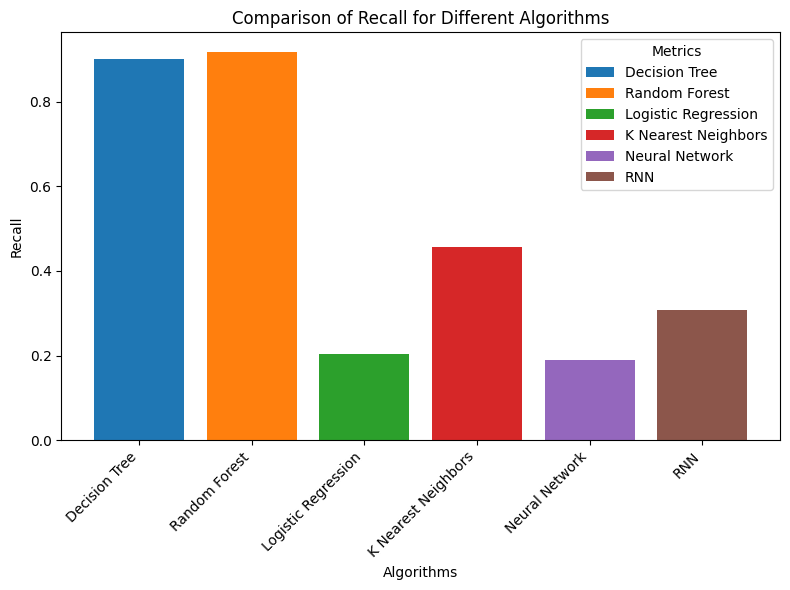

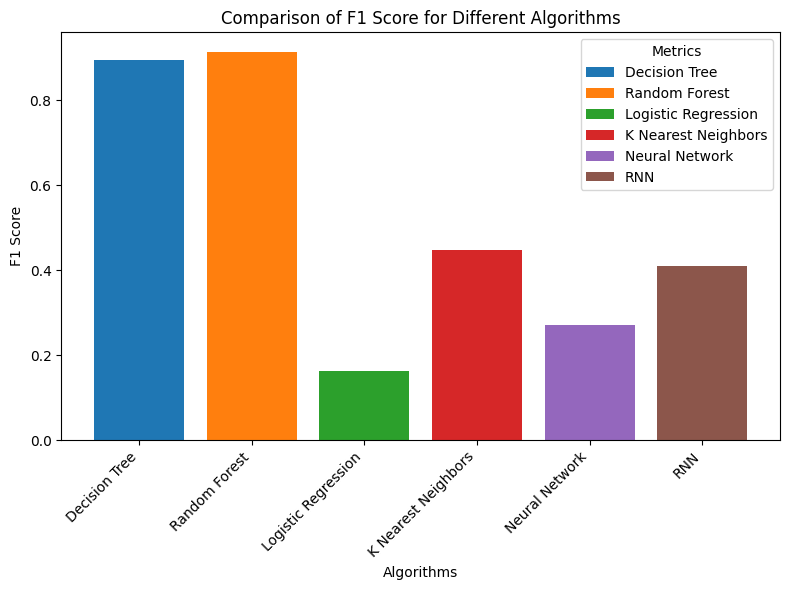

In [ ]:
# Define the metrics for each algorithm
metrics = {
    'Decision Tree': [dt_accuracy, dt_precision, dt_recall, dt_f1],
    'Random Forest': [rf_accuracy, rf_precision, rf_recall, rf_f1],
    'Logistic Regression': [lr_accuracy, lr_precision, lr_recall, lr_f1],
    'K Nearest Neighbors': [knn_accuracy, knn_precision, knn_recall, knn_f1],
    'Neural Network': [accuracy, precision_val, recall_val, f1_val],
    'RNN': [rnn_accuracy, rnn_precision, rnn_recall, rnn_f1]
}

# Define the metrics labels
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plot each metric separately
for i, metric in enumerate(metric_labels):
    plt.figure(figsize=(8, 6))
    for algo, scores in metrics.items():
        plt.bar(algo, scores[i], label=algo)
    plt.title(f'Comparison of {metric} for Different Algorithms')
    plt.xlabel('Algorithms')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metrics', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


In [ ]:
from tabulate import tabulate

# Define the results dictionary
results = {
    "Model": ["Decision Tree", "Random Forest", "Logistic Regression", "K Nearest Neighbors", "Neural Network", "RNN"],
    "Accuracy": [dt_accuracy, rf_accuracy, lr_accuracy, knn_accuracy, accuracy, rnn_accuracy],
    "Precision": [dt_precision, rf_precision, lr_precision, knn_precision, precision_val, rnn_precision],
    "Recall": [dt_recall, rf_recall, lr_recall, knn_recall, recall_val, rnn_recall],
    "F1 Score": [dt_f1, rf_f1, lr_f1, knn_f1, f1_val, rnn_f1]
}

# Print the results as a table
print(tabulate(results, headers="keys", tablefmt="grid"))


+---------------------+------------+-------------+----------+------------+
| Model               |   Accuracy |   Precision |   Recall |   F1 Score |
+=====================+============+=============+==========+============+
| Decision Tree       |   0.902452 |    0.899198 | 0.902452 |   0.893852 |
+---------------------+------------+-------------+----------+------------+
| Random Forest       |   0.918456 |    0.916308 | 0.918456 |   0.913515 |
+---------------------+------------+-------------+----------+------------+
| Logistic Regression |   0.203699 |    0.192294 | 0.203699 |   0.162243 |
+---------------------+------------+-------------+----------+------------+
| K Nearest Neighbors |   0.45625  |    0.44389  | 0.45625  |   0.447135 |
+---------------------+------------+-------------+----------+------------+
| Neural Network      |   0.283    |    0.47782  | 0.1885   |   0.270348 |
+---------------------+------------+-------------+----------+------------+
| RNN                 |  